In [1]:
from functools import partial

import jax
import jax.numpy as np
import flax.linen as nn
import optax
import diffrax as dfx
import math
import distrax

from sklearn import datasets, preprocessing

import matplotlib.pyplot as plt
from tqdm import trange

(-2.0, 2.0)

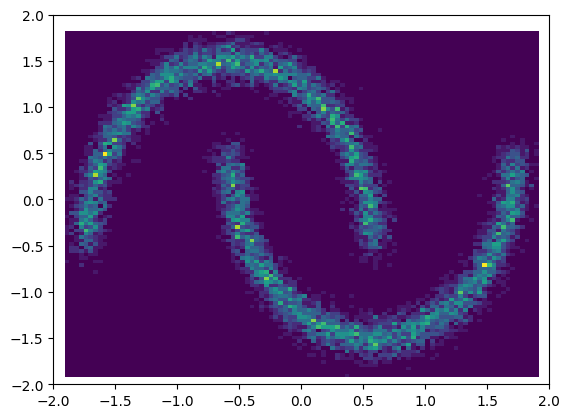

In [2]:
n_samples = 10_000

x, _ = datasets.make_moons(n_samples=n_samples, noise=.06)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

plt.hist2d(x[:, 0], x[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

In [92]:
class MLP(nn.Module):
    """ A simple MLP in Flax.
    """
    hidden_dim: int = 64
    out_dim: int = 2
    n_layers: int = 3

    @nn.compact
    def __call__(self, x):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x

In [93]:
key = jax.random.PRNGKey(0)
t = np.ones((x.shape[0], 1))

phi = MLP(hidden_dim=64, out_dim=2, n_layers=3)
params = phi.init(key, np.concatenate([x, t], axis=1))

In [94]:
# def log_prob(y):
#     # TODO
#     pass

In [104]:
sigma_min = 1e-4

def loss_fn(params, x, t, eps, phi):
    t = np.atleast_1d(t)
    y = (1 - t) * x + (sigma_min + (1 - sigma_min) * t) * eps
    u = (1 - sigma_min) * eps - x    
    return np.square(phi.apply(params, np.concatenate([y, t], -1)) - u).mean()

loss_fn(params, x, t, np.zeros_like(x), phi)

Array(1.0051274, dtype=float32)

In [105]:
opt = optax.adamw(learning_rate=3e-4, weight_decay=1e-4)
opt_state = opt.init(params)

In [107]:
n_steps = 5000
n_batch = 64

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]
        
        # Draw uniform times
        t_batch = jax.random.uniform(subkey, (n_batch, 1))
        eps = jax.random.normal(subkey, (n_batch, 2))
        
        loss, grads = jax.value_and_grad(loss_fn)(params, x_batch, t_batch, eps, phi)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

In [112]:
t0, t1, dt0 = 1., 0., 1e-2

def single_sample_fn(params, key, n_dim=2):
    """ Produce single sample from the CNF by integrating forward.
    """
    y = jax.random.normal(key, (n_dim,))
    def func(t, x, args):
        t = np.atleast_1d(t)
        return phi.apply(params, np.concatenate([x, t]))
    term = dfx.ODETerm(func)
    solver = dfx.Euler()
    sol = dfx.diffeqsolve(term, solver, t0, t1, -dt0, y)
    (y,) = sol.ys
    return y

single_sample_fn(params, key)

Array([ 0.697109  , -0.49419156], dtype=float32, weak_type=True)

In [113]:
sample_fn = partial(single_sample_fn, params)

n_samples = 500
sample_key = jax.random.split(key, n_samples ** 2)
x_sample = jax.vmap(sample_fn)(sample_key)

(-2.0, 2.0)

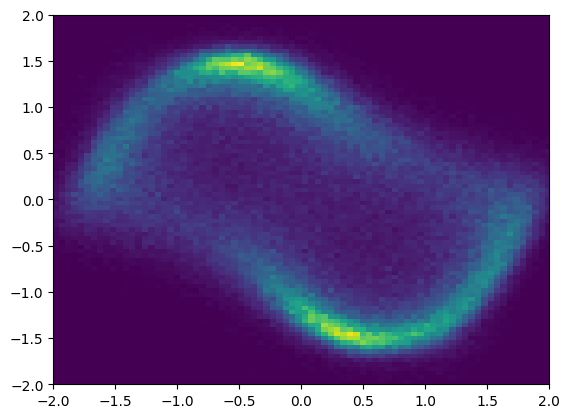

In [114]:

plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)